In [ ]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = None
# For plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
import torchvision.models as models
from torchvision.io import read_image
from torchvision import datasets, transforms    
# For utilities
import os, shutil, time
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from skimage import io, color
from sklearn.model_selection import train_test_split
# Check if GPU is available
use_gpu = torch.cuda.is_available()

In [ ]:
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):   
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
        elif split == 'test':
            self.transforms = transforms.Resize((SIZE, SIZE))
        
        self.split = split
        self.size = SIZE
        self.paths = paths
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        
        return {'L': L, 'ab': ab}
    
    def __len__(self):
        return len(self.paths)
    
# Pfade zu den Bildern
image_dir = 'dataset/student_dataset/train/images'
image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir)]


# Aufteilung in Trainings- und Validierungsbilder
train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

# Apply augmentation only to the training dataset
train_dataset = ColorizationDataset(train_files)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Erstellen des Validierungsdatasets und Dataloaders
val_dataset = ColorizationDataset(val_files)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
data = next(iter(train_loader))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_loader), len(val_loader))

In [ ]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

In [ ]:
def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

In [ ]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
    
def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")
        
        
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

In [ ]:
def train_model(model, train_dl, epochs, display_every=200, min_g_loss=10):
    data = next(iter(val_loader)) # getting a batch for visualizing the model output after fixed intrvals
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to 
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses
                visualize(model, data, save=True) # function displaying the model's outputs
            
            # Check generator loss and save model if it's smaller than the threshold
            if loss_meter_dict['loss_G'].avg < min_g_loss:
                min_g_loss = loss_meter_dict['loss_G'].avg
                torch.save(model.state_dict(), "GANModels/colorization_model.pth")

min_g_loss = 10.0
model = MainModel()
train_model(model, train_loader, 100, display_every=71, min_g_loss=min_g_loss)
torch.save(model.state_dict(), "GANModels/colorization_model.pth")

In [69]:
def test(test_loader, model):
    model.eval()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    for data in tqdm(test_loader):
        # throw away class predictions
        visualizefortest(model, data, save=True) # function displaying the model's outputs
            
    print('Finished testing.')

import os

def visualizefortest(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    print(fake_imgs.shape)
    
    os.makedirs("GANTest", exist_ok=True)  # Create the GANTest folder if it doesn't exist
    
    for i, fake_img in enumerate(fake_imgs):
        filename = f"GANTest/fake_{i}.jpg"  # Generate a unique filename for each fake image
        plt.imsave(filename, fake_img)


In [70]:
# Define the path to the test dataset
test_data_path = "dataset/student_dataset/test_color"

# Define the transformation to be applied to the test images
# Define the transformation to be applied to the test images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert the image to grayscale (1 channel)
    transforms.ToTensor()  # Convert the image to a PyTorch tensor
])

# Pfade zu den Bildern
image_dir = 'dataset/student_dataset/test_color/images'
image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir)]
image_files.sort()  # Sort the file names in ascending order

# Apply augmentation only to the training dataset
test_dataset = ColorizationDataset(image_files, split="test")
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = MainModel()
model.load_state_dict(torch.load("GANModels/colorization_model.pth"))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

test(test_loader, model)

model initialized with norm initialization
model initialized with norm initialization


  0%|          | 0/1 [00:00<?, ?it/s]

(50, 256, 256, 3)
Finished testing.


['fake_0.jpg', 'fake_1.jpg', 'fake_2.jpg', 'fake_3.jpg', 'fake_4.jpg', 'fake_5.jpg', 'fake_6.jpg', 'fake_7.jpg', 'fake_8.jpg', 'fake_9.jpg', 'fake_10.jpg', 'fake_11.jpg', 'fake_12.jpg', 'fake_13.jpg', 'fake_14.jpg', 'fake_15.jpg', 'fake_16.jpg', 'fake_17.jpg', 'fake_18.jpg', 'fake_19.jpg', 'fake_20.jpg', 'fake_21.jpg', 'fake_22.jpg', 'fake_23.jpg', 'fake_24.jpg', 'fake_25.jpg', 'fake_26.jpg', 'fake_27.jpg', 'fake_28.jpg', 'fake_29.jpg', 'fake_30.jpg', 'fake_31.jpg', 'fake_32.jpg', 'fake_33.jpg', 'fake_34.jpg', 'fake_35.jpg', 'fake_36.jpg', 'fake_37.jpg', 'fake_38.jpg', 'fake_39.jpg', 'fake_40.jpg', 'fake_41.jpg', 'fake_42.jpg', 'fake_43.jpg', 'fake_44.jpg', 'fake_45.jpg', 'fake_46.jpg', 'fake_47.jpg', 'fake_48.jpg', 'fake_49.jpg']


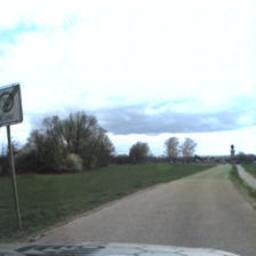

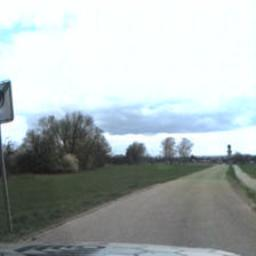

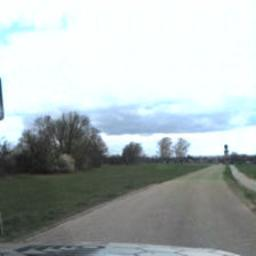

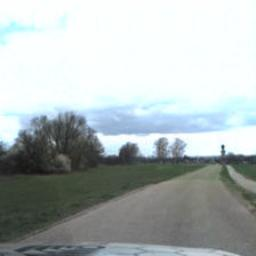

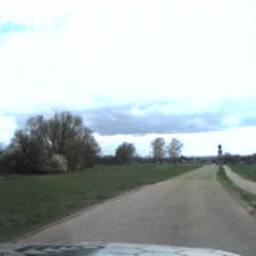

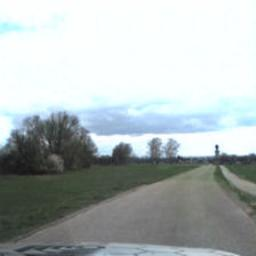

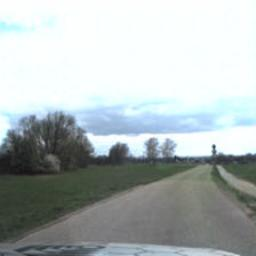

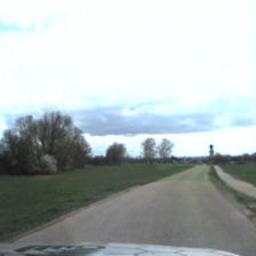

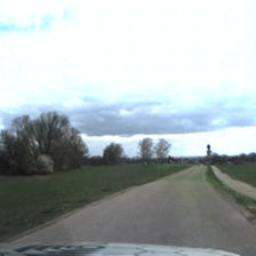

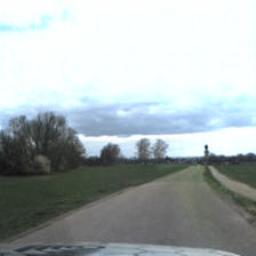

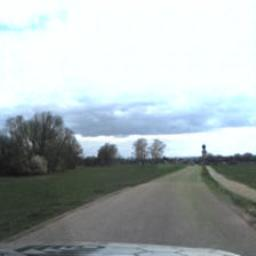

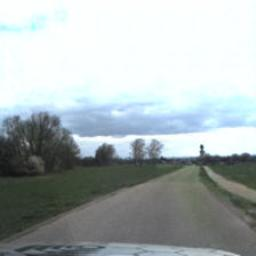

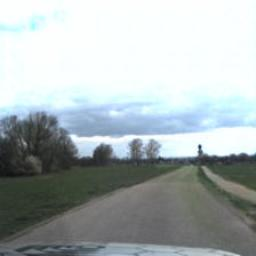

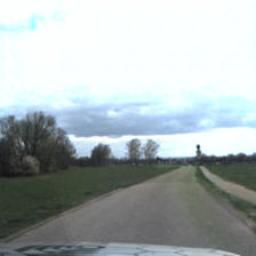

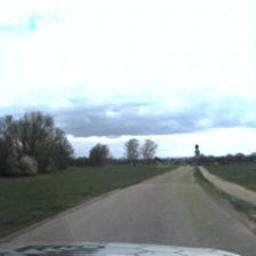

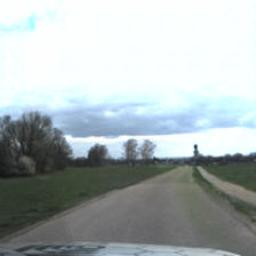

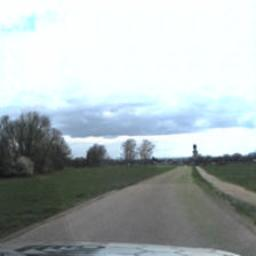

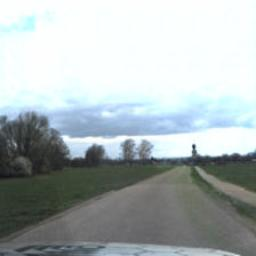

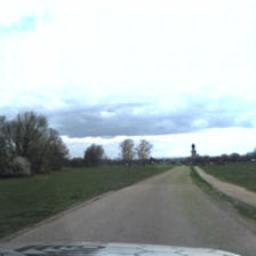

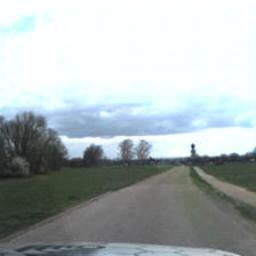

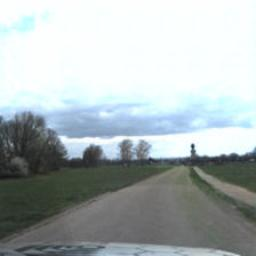

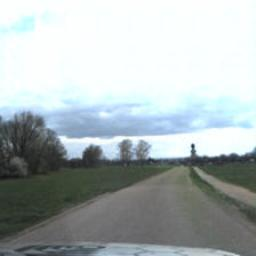

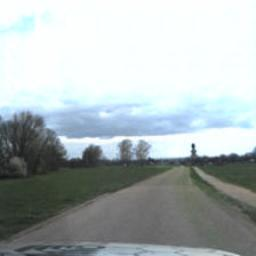

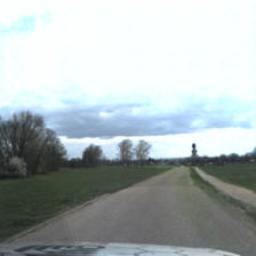

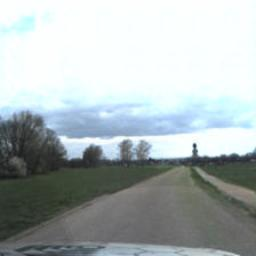

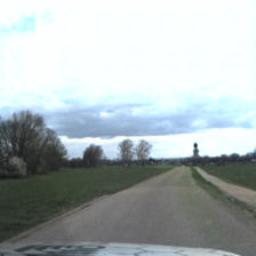

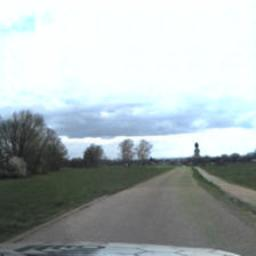

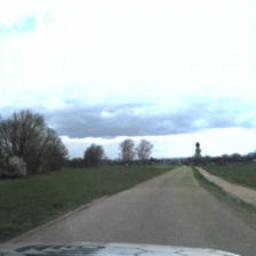

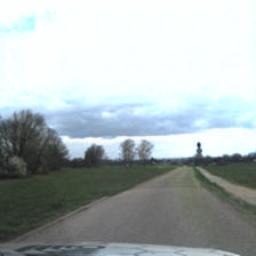

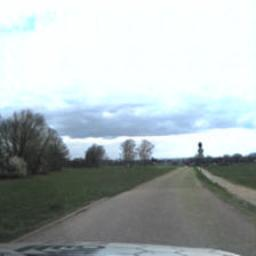

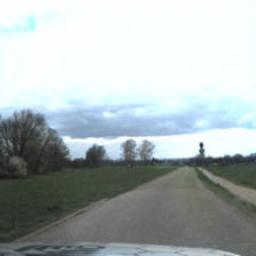

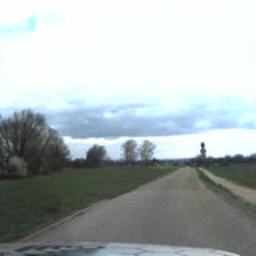

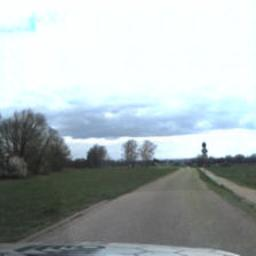

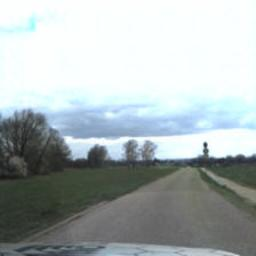

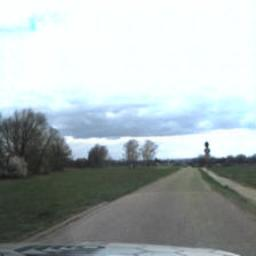

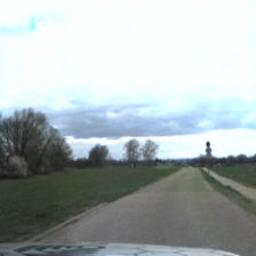

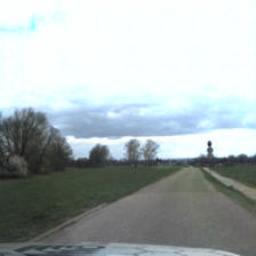

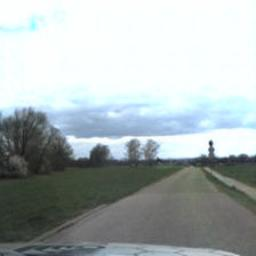

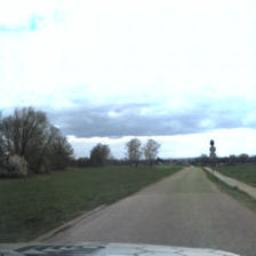

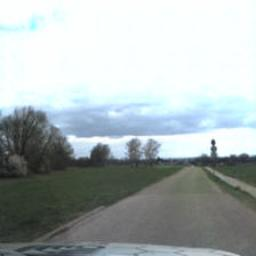

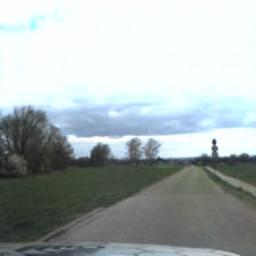

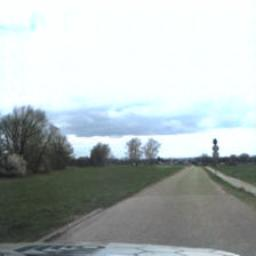

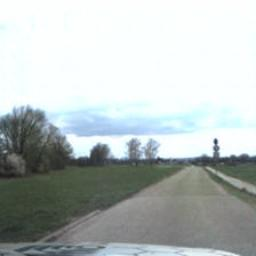

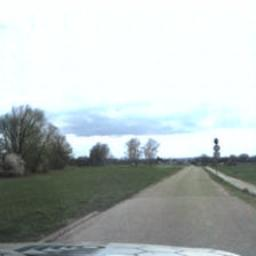

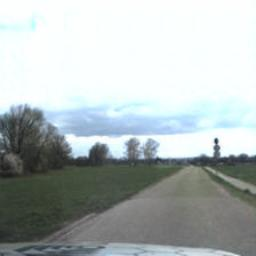

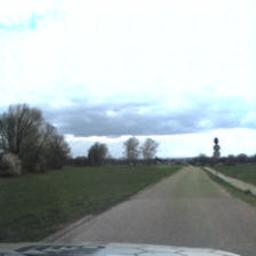

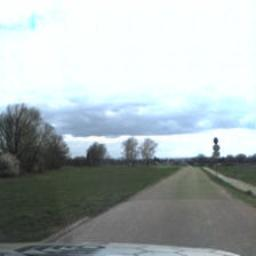

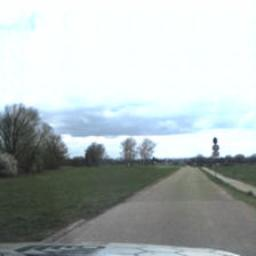

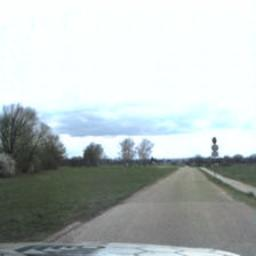

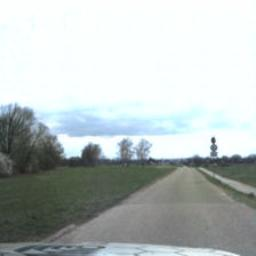

Array shape: (50, 224, 224, 3)
Array saved as 'image_array.npy'


In [75]:
import os
from PIL import Image
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import re

# Path to the folder containing the JPEG files
folder_path = "GANTest"

# Initialize an empty array to store the images
image_array = np.zeros((50, 224, 224, 3), dtype=np.uint8)

# List all files in the folder
files = os.listdir(folder_path)
files = sorted(files, key=lambda x: int(re.findall(r'\d+', x)[0]))
print(files)

# Iterate over each file in the folder
for i, file_name in enumerate(files):
    # Construct the full file path
    file_path = os.path.join(folder_path, file_name)
    
    # Open the image using PIL
    image = Image.open(file_path)
    
    image.show()    

    # Resize the image to 224x224
    resized_image = image.resize((224, 224))
    
    # Convert the image to a numpy array and store it in the image_array
    image_array[i] = np.array(resized_image)

# Save the array as a NumPy file
np.save("image_array.npy", image_array)

# Print the shape of the resulting array
print("Array shape:", image_array.shape)
print("Array saved as 'image_array.npy'")
